In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
from google.colab import drive

# drive.mount('/content/drive')

ads_choice = ['real-ads', 'real-ads-cap', 'few-shots', 'zero-shot']
ads = ads_choice[3]

import_model = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Ads and Embeddings

**Real Ads**

In [ ]:
# Load data
main_pages_data = pd.read_csv('data/cl_real_ads_embeddings.csv')

# Convert 'bert_embeddings' column back to lists of floats
main_pages_data['bert_embeddings'] = main_pages_data['bert_embeddings'].apply(lambda x: np.array(list(map(float, x.split(',')))))

# Get ordered embeddings by party
main_parties = sorted(main_pages_data['party'].unique())

main_parties_labels = ["Complete\nDataset", "3POLO", "AVD", "FDI", "FI", "LEGA", "M5S", "PD"]

# Get ordered embeddings by party
ra_ordered_embeddings = []
ra_party_labels = []

cap_size = 50

for i, party in enumerate(main_parties):
    party_embeddings = main_pages_data[main_pages_data['party'] == party]['bert_embeddings'].to_numpy()

    if ads == 'real-ads-cap':
        # Limit to cap_size embeddings
        ra_ordered_embeddings.extend(party_embeddings[:cap_size])
        ra_party_labels.extend([i] * len(party_embeddings[:cap_size]))
    else:
        ra_ordered_embeddings.extend(party_embeddings)
        ra_party_labels.extend([i] * len(party_embeddings))

ra_ordered_embeddings = np.vstack(ra_ordered_embeddings)
ra_party_labels = np.array(ra_party_labels)


ra_ordered_text = main_pages_data['ad_creative_bodies'].tolist()

print(len(ra_ordered_embeddings), len(ra_party_labels), len(ra_ordered_text))


635 635 635


**[3.1] Few Shots**

In [ ]:
# Load the CSV file
fs_gen_text_embeddings_df = pd.read_csv('data/mp_gen_text_party_2_embeddings.csv')

ads_per_party = 100

# Convert the 'gen_text_embeddings' column back to lists of NumPy arrays
fs_gen_text_embeddings_df['gen_text_embeddings'] = fs_gen_text_embeddings_df['gen_text_embeddings'].apply(
    lambda x: [np.array(list(map(float, embedding.split(',')))) for embedding in x.split('|')]
)

# Add the 'party' column from the main_parties list
fs_gen_text_embeddings_df['party'] = main_parties

# Reorder columns to place 'party' first
fs_gen_text_embeddings_df = fs_gen_text_embeddings_df[['party', 'gen_text_embeddings']]

# # Get ordered embeddings by party
fs_ordered_embeddings = np.vstack([np.vstack(fs_gen_text_embeddings_df[fs_gen_text_embeddings_df['party'] == party]['gen_text_embeddings'].to_numpy())
                                   for party in main_parties])

# Generate labels for each party
fs_party_labels = np.concatenate([np.full(ads_per_party, i)
                               for i, party in enumerate(main_parties)])

# Import the CSV file
fs_gen_text_df = pd.read_csv('data/mp_generated_ads_party_2.csv')
# Convert the 'top_ads' column to lists of strings
fs_gen_text_df['gen_plain_list'] = fs_gen_text_df['gen_plain_list'].apply(eval)

fs_ordered_text = [text for sublist in fs_gen_text_df['gen_plain_list'] for text in sublist]

print(len(fs_ordered_embeddings), len(fs_party_labels), len(fs_ordered_text))


700 700 700


**[4] Zero Shot**

In [ ]:
# Load the CSV file
zs_gen_text_embeddings_df = pd.read_csv('data/zero_shot_gen_embeddings.csv')

ads_per_party = 111

# Convert the 'gen_text_embeddings' column back to lists of NumPy arrays
zs_gen_text_embeddings_df['gen_text_embeddings'] = zs_gen_text_embeddings_df['gen_text_embeddings'].apply(
    lambda x: [np.array(list(map(float, embedding.split(',')))) for embedding in x.split('|')]
)

# Add the 'party' column from the main_parties list
zs_gen_text_embeddings_df['party'] = main_parties

# Reorder columns to place 'party' first
zs_gen_text_embeddings_df = zs_gen_text_embeddings_df[['party', 'gen_text_embeddings']]

# # Get ordered embeddings by party
zs_ordered_embeddings = np.vstack([np.vstack(zs_gen_text_embeddings_df[zs_gen_text_embeddings_df['party'] == party]['gen_text_embeddings'].to_numpy())
                                   for party in main_parties])

# Generate labels for each party
zs_party_labels = np.concatenate([np.full(ads_per_party, i)
                               for i, party in enumerate(main_parties)])

# Import the CSV file
zero_shot_gen_text_df = pd.read_csv('data/zero_shot_generated_ads.csv')
# Convert the 'top_ads' column to lists of strings
zero_shot_gen_text_df['gen_plain_list'] = zero_shot_gen_text_df['gen_plain_list'].apply(eval)

zs_ordered_text = [text for sublist in zero_shot_gen_text_df['gen_plain_list'] for text in sublist]

print(len(zs_ordered_embeddings), len(zs_party_labels), len(zs_ordered_text))


777 777 777


# Data Prep

In [96]:
def create_pairs(embeddings, labels):
    '''Create pairs where each pair's party label is based on the first item in the pair'''
    pairs, labels_out, party_labels_out = [], [], []
    num_classes = len(np.unique(labels))
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    # Create positive pairs within each party
    for idx in range(num_classes):
        class_idx = class_indices[idx]
        for i in range(len(class_idx)):
            for j in range(i + 1, len(class_idx)):
                pairs.append([embeddings[class_idx[i]], embeddings[class_idx[j]]])
                labels_out.append(1)  # Positive pair
                party_labels_out.append(idx)  # Party label is from the first item in the pair

    # Create negative pairs across different parties
    num_positive_pairs = len(labels_out)
    print(f"Number of positive pairs: {num_positive_pairs}")
    while len(labels_out) < 2 * num_positive_pairs:
        # Randomly select two different classes
        idx1, idx2 = random.sample(range(num_classes), 2)
        i = random.choice(class_indices[idx1])
        j = random.choice(class_indices[idx2])

        pairs.append([embeddings[i], embeddings[j]])
        labels_out.append(0)  # Negative pair
        party_labels_out.append(idx1)  # Party label is from the first item in the pair
    print(f"Number of negative pairs: {len(labels_out) - num_positive_pairs}")

    return np.array(pairs), np.array(labels_out), np.array(party_labels_out)


In [ ]:
match ads:
    case 'real-ads':
        ordered_embeddings = ra_ordered_embeddings
        party_labels = ra_party_labels
        ordered_text = ra_ordered_text
    case 'real-ads-cap':
        ordered_embeddings = ra_ordered_embeddings
        party_labels = ra_party_labels
        ordered_text = ra_ordered_text
    case 'few-shots':
        ordered_embeddings = fs_ordered_embeddings
        party_labels = fs_party_labels
        ordered_text = fs_ordered_text
    case 'zero-shot':
        ordered_embeddings = zs_ordered_embeddings
        party_labels = zs_party_labels
        ordered_text = zs_ordered_text

model_file_path = f"models/SN_model_{ads}.h5"
weights_file_path = f"models/SN_{ads}.weights.h5"

input_dim = ordered_embeddings.shape[1]

print(ads, len(ordered_embeddings), len(party_labels), len(ordered_text))

zero-shot 777 777 777


In [98]:
ordered_embeddings.shape[0]

777

In [99]:
# Create pairs and labels
pairs, labels_out, party_labels_out = create_pairs(ordered_embeddings, party_labels)
print(f"Number of pairs: {len(pairs)}\n")     # 100*99/2 * 7 * 2

all_embeddings = pairs.reshape(-1, pairs.shape[-1])  # Flatten all embedding pairs
unique_embeddings = np.unique(all_embeddings, axis=0)  # Get unique embeddings
print(f"Number of unique embeddings: {len(unique_embeddings)}")
# Split unique embeddings into train and test sets
# train_embeddings, test_embeddings = train_test_split(ordered_embeddings, test_size=0.2, random_state=42)

# Initialize StratifiedShuffleSplit with the same test size and random state
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Generate train-test indices
for train_index, test_index in split.split(ordered_embeddings, party_labels):
    train_embeddings, test_embeddings = ordered_embeddings[train_index], ordered_embeddings[test_index]
    train_labels, test_labels = party_labels[train_index], party_labels[test_index]

# Verify the distribution in training and test sets
print(f"Number of train embeddings: {len(train_embeddings)}")
unique, train_counts = np.unique(train_labels, return_counts=True)
print("Training set party distribution:", dict(zip(unique, train_counts)))

print(f"Number of test embeddings: {len(test_embeddings)}")
unique, test_counts = np.unique(test_labels, return_counts=True)
print("Test set party distribution:", dict(zip(unique, test_counts)))


# Convert train and test embeddings into sets for fast membership checking
train_embeddings_set = set(map(tuple, train_embeddings))
test_embeddings_set = set(map(tuple, test_embeddings))

# Filter the pairs and party labels
train_indices = []
test_indices = []

for i, pair in enumerate(pairs):
    embedding_a, embedding_b = tuple(pair[0]), tuple(pair[1])

    if embedding_a in train_embeddings_set and embedding_b in train_embeddings_set:
        train_indices.append(i)

    if embedding_a in test_embeddings_set and embedding_b in test_embeddings_set:
        test_indices.append(i)

# Final training and testing sets
X_train = pairs[train_indices]
y_train = labels_out[train_indices]
party_labels_train = party_labels_out[train_indices]
print(f"\nNumber of train pairs: {len(X_train)}")

X_test = pairs[test_indices]
y_test = labels_out[test_indices]
party_labels_test = party_labels_out[test_indices]  # Use for per-party evaluation
print(f"Number of test pairs: {len(X_test)}")

# Check for overlap between training and test sets
train_flat_embeddings = X_train.reshape(-1, X_train.shape[-1])
test_flat_embeddings = X_test.reshape(-1, X_test.shape[-1])
# Convert embeddings to sets for comparison
train_flat_embeddings_set = set(map(tuple, train_flat_embeddings))
test_flat_embeddings_set = set(map(tuple, test_flat_embeddings))
# Find overlap
overlap = train_flat_embeddings_set.intersection(test_flat_embeddings_set)
print(f"Overlap between training and test embeddings: {len(overlap)}")  # Should be 0

Number of positive pairs: 42735
Number of negative pairs: 42735
Number of pairs: 85470

Number of unique embeddings: 767
Number of train embeddings: 621
Training set party distribution: {0: 89, 1: 89, 2: 89, 3: 88, 4: 89, 5: 89, 6: 88}
Number of test embeddings: 156
Test set party distribution: {0: 22, 1: 22, 2: 22, 3: 23, 4: 22, 5: 22, 6: 23}

Number of train pairs: 54772
Number of test pairs: 3523
Overlap between training and test embeddings: 2


# Model

In [100]:
# Define the base network (shared across both branches)
def create_base_network(input_dim):
    input = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(input)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    return Model(input, x)

# Define contrastive loss function
def contrastive_loss(y_true, y_pred, margin=2.0):
    '''Contrastive loss function'''
    y_true = tf.cast(y_true, y_pred.dtype)
    margin = tf.cast(margin, y_pred.dtype)
    squared_pred = tf.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * squared_pred + (1 - y_true) * margin_squared)

# Define the Euclidean distance function for the Lambda layer
def euclidean_distance(embeddings):
    return tf.sqrt(tf.maximum(
        tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=1),
        1e-9
    ))

# Build the Siamese network
def build_siamese_network(input_dim):
    base_network = create_base_network(input_dim)
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = Lambda(euclidean_distance, output_shape=(1,), name='euclidean_distance')([processed_a, processed_b])
    model = Model([input_a, input_b], distance)
    return model


In [101]:
# Function to save the entire model
def save_model(model, filepath):
    model.save(filepath)

# Function to save only the model weights
def save_weights(model, filepath):
    model.save_weights(filepath)

# Function to load the entire model
def load_model(filepath):
    return tf.keras.models.load_model(
        filepath,
        custom_objects={
            'contrastive_loss': contrastive_loss,
            'euclidean_distance': euclidean_distance
        }
    )

# Function to load the model weights
def load_weights(input_dim, filepath):
    model = build_siamese_network(input_dim)
    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-5))
    model.load_weights(filepath)
    return model

In [102]:
if not import_model:

    # Build the model
    model = build_siamese_network(input_dim)
    # Compile the model
    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-5))

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                        validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
                        batch_size=16, epochs=100, callbacks=[early_stopping])

    # Save the entire model
    save_model(model, model_file_path)

    # Save only the weights
    save_weights(model, weights_file_path)


    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

In [103]:
# # Load the entire model
# model = load_model(model_file_path)
model = load_weights(input_dim, weights_file_path)
print(f"Model loaded from {model_file_path}")

Model loaded from /content/drive/MyDrive/MasterThesis/Mencarelli_MT_Notebooks/Mencarelli_MT_LLM-IT22/models/SN_model_zero-shot.h5


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [104]:
model.summary(expand_nested=True, show_trainable=False)

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55            │ (None, 768)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_56            │ (None, 768)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_36             │ (None, 64)             │        238,016 │ input_layer_55[0][0],  │
│ (Functional)              │                        │                │ input_layer_56[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ input_layer_54       │ (None, 768)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ dense_54 (Dense)     │ (None, 256)            │        196,864 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ dropout_36 (Dropout) │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ dense_55 (Dense)     │ (None, 128)            │         32,896 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ dropout_37 (Dropout) │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ dense_56 (Dense)     │ (None, 64)             │          8,256 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ euclidean_distance        │ (None, 1)              │              0 │ functional_36[0][0],   │
│ (Lambda)                  │                        │                │ functional_36[1][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 238,016 (929.75 KB)

 Trainable params: 238,016 (929.75 KB)

 Non-trainable params: 0 (0.00 B)

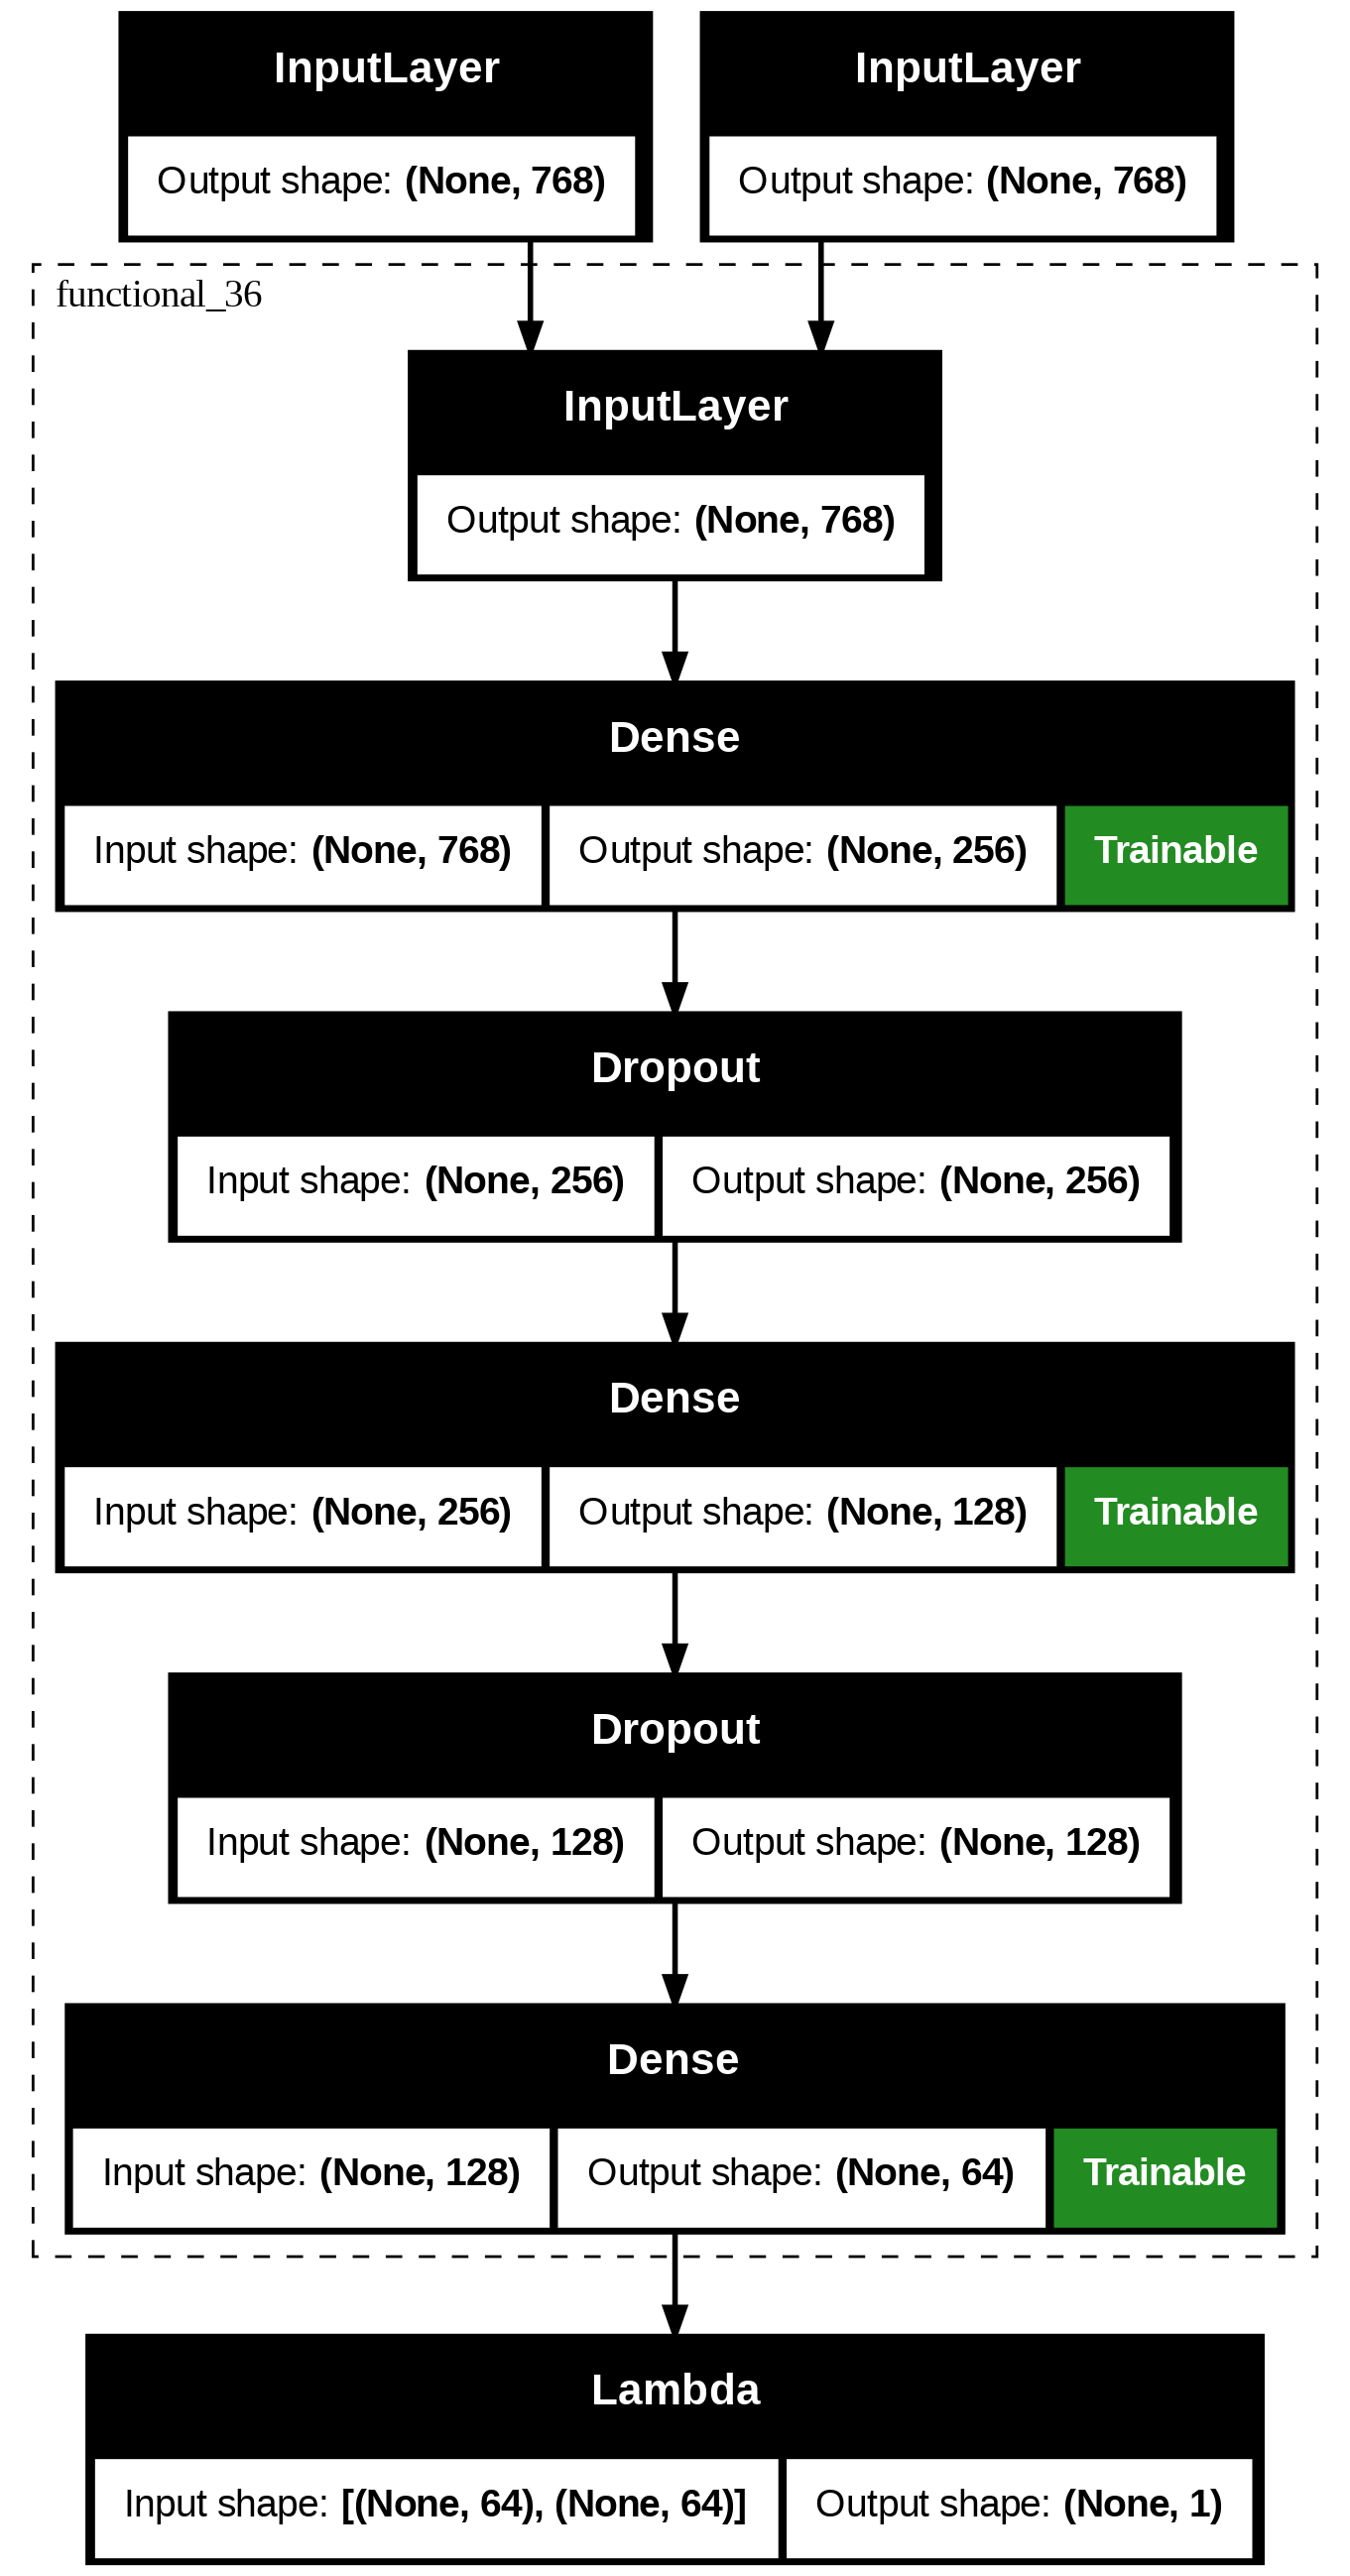

In [105]:
plot_model(model, show_shapes=True, show_layer_names=False, expand_nested=True, show_trainable=True)

In [106]:
# Evaluate the model
loss = model.evaluate([X_test[:,0], X_test[:,1]], y_test)
print(f'Test Loss: {loss}')

# Predict distances
distances = model.predict([X_test[:,0], X_test[:,1]])

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0371
Test Loss: 0.023538950830698013
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Threshold and Metrics

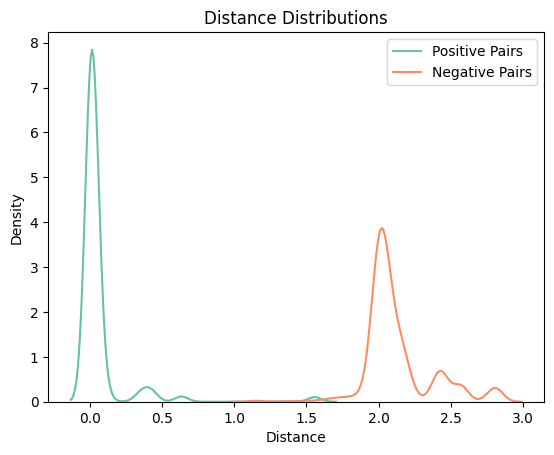

In [107]:
# Plotting distance distributions
positive_distances = distances[y_test == 1]
negative_distances = distances[y_test == 0]

sns.kdeplot(positive_distances.ravel(), label='Positive Pairs')
sns.kdeplot(negative_distances.ravel(), label='Negative Pairs')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Distance Distributions')
plt.legend()
plt.show()

In [108]:
# Calculate the means
mean_positive = np.mean(positive_distances)
mean_negative = np.mean(negative_distances)
median_positive = np.median(positive_distances)
median_negative = np.median(negative_distances)

# Set threshold to the midpoint between the means
midpoint_threshold = (mean_positive + mean_negative) / 2
y_pred_test = distances <= midpoint_threshold
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(f"midpoint_threshold: {midpoint_threshold:.2f}, Accuracy: {accuracy:.3f}, F1-score: {f1:.4f}")

midpoint_median = (median_positive + median_negative) / 2
y_pred_test = distances <= midpoint_median
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(f"midpoint_median: {midpoint_median:.2f}, Accuracy: {accuracy:.3f}, F1-score: {f1:.4f}")

for threshold_test in np.linspace(midpoint_threshold - 0.2, midpoint_threshold + 0.2, num=10):
    y_pred_test = distances <= threshold_test
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    print(f"Threshold_test: {threshold_test:.2f}, Accuracy: {accuracy:.3f}, F1-score: {f1:.4f}")

midpoint_threshold: 1.10, Accuracy: 0.994, F1-score: 0.9938
midpoint_median: 1.03, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 0.90, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 0.94, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 0.98, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 1.03, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 1.07, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 1.12, Accuracy: 0.994, F1-score: 0.9938
Threshold_test: 1.16, Accuracy: 0.993, F1-score: 0.9923
Threshold_test: 1.21, Accuracy: 0.993, F1-score: 0.9923
Threshold_test: 1.25, Accuracy: 0.993, F1-score: 0.9923
Threshold_test: 1.30, Accuracy: 0.993, F1-score: 0.9923


In [109]:
# Set threshold and calculate accuracy
# threshold = 0.6
y_pred = (distances <= midpoint_threshold).astype('float32')
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.4f}')

Test Accuracy: 0.9940
F1-score: 0.9938


In [110]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f'{ads} | SN Confusion Matrix:')
print(cm)

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Dissimilar', 'Similar'])
print(f'{ads} | SN Classification Report:')
print(report)

zero-shot | SN Confusion Matrix:
[[1817    0]
 [  21 1685]]
zero-shot | SN Classification Report:
              precision    recall  f1-score   support

  Dissimilar       0.99      1.00      0.99      1817
     Similar       1.00      0.99      0.99      1706

    accuracy                           0.99      3523
   macro avg       0.99      0.99      0.99      3523
weighted avg       0.99      0.99      0.99      3523



# Tests

In [111]:
count_out = {}
print("Count potential party labels:\n")
for label in party_labels_out:
    if main_parties[label] not in count_out:
        count_out[main_parties[label]] = 0
    count_out[main_parties[label]] += 1
count_out

Count potential party labels:



{"['3POLO']": 12086,
 "['AVD']": 12194,
 "['FDI']": 12332,
 "['FI']": 12171,
 "['LEGA']": 12222,
 "['M5S']": 12234,
 "['PD']": 12231}

In [112]:
print("Count train+test party labels:\n")
count_tt = {}
for label in party_labels_train:
    if main_parties[label] not in count_tt:
        count_tt[main_parties[label]] = 0
    count_tt[main_parties[label]] += 1
for label in party_labels_test:
    count_tt[main_parties[label]] += 1
count_tt

Count train+test party labels:



{"['3POLO']": 8251,
 "['AVD']": 8361,
 "['FDI']": 8425,
 "['FI']": 8329,
 "['LEGA']": 8385,
 "['M5S']": 8301,
 "['PD']": 8243}

In [113]:
print("Count train party labels:\n")
unique_values, counts = np.unique(party_labels_train, return_counts=True)
result = dict(zip(unique_values, counts))
print(result)

Count train party labels:

{0: 7781, 1: 7870, 2: 7939, 3: 7776, 4: 7878, 5: 7824, 6: 7704}


In [114]:
print("Count test party labels:\n")
unique_values, counts = np.unique(party_labels_test, return_counts=True)
result = dict(zip(unique_values, counts))
print(result)

Count test party labels:

{0: 470, 1: 491, 2: 486, 3: 553, 4: 507, 5: 477, 6: 539}


precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [239 231]
Party: ['3POLO']
  - F1 Score: 1.000
  - Accuracy: 1.000
  - Number of Test Samples: 470



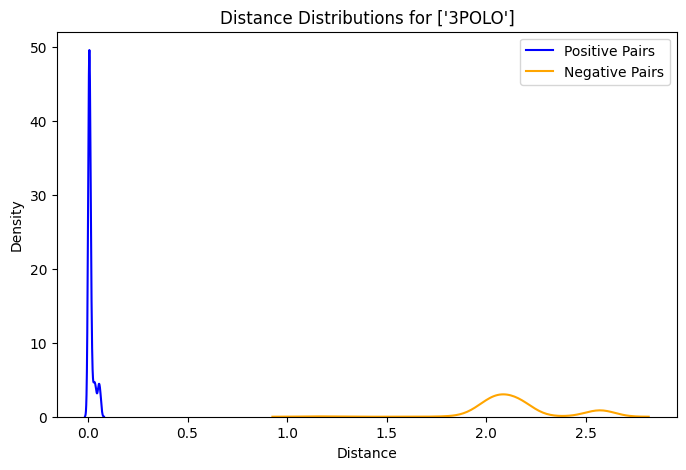

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [260 231]
Party: ['AVD']
  - F1 Score: 1.000
  - Accuracy: 1.000
  - Number of Test Samples: 491



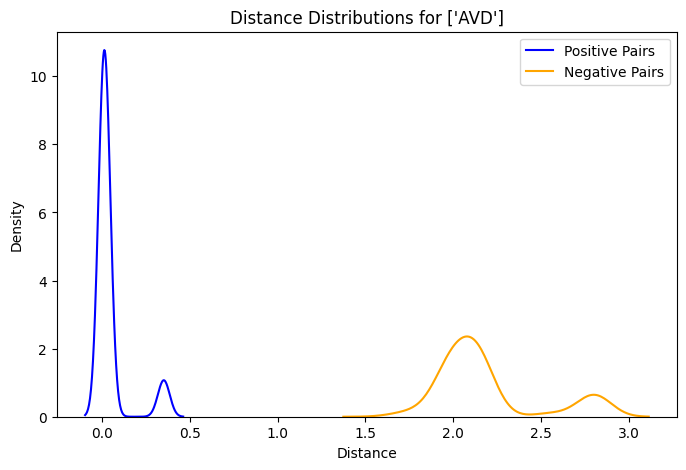

precision: [0.92391304 1.        ]
recall: [1.         0.90909091]
fscore: [0.96045198 0.95238095]
support: [255 231]
Party: ['FDI']
  - F1 Score: 0.952
  - Accuracy: 0.957
  - Number of Test Samples: 486



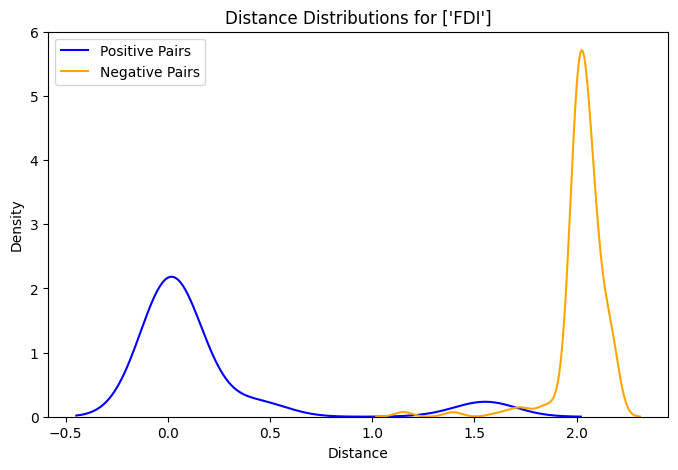

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [277 276]
Party: ['FI']
  - F1 Score: 1.000
  - Accuracy: 1.000
  - Number of Test Samples: 553



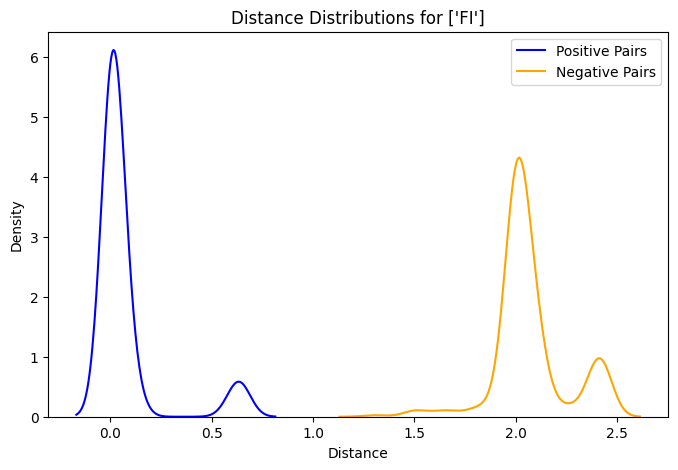

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [254 253]
Party: ['LEGA']
  - F1 Score: 1.000
  - Accuracy: 1.000
  - Number of Test Samples: 507



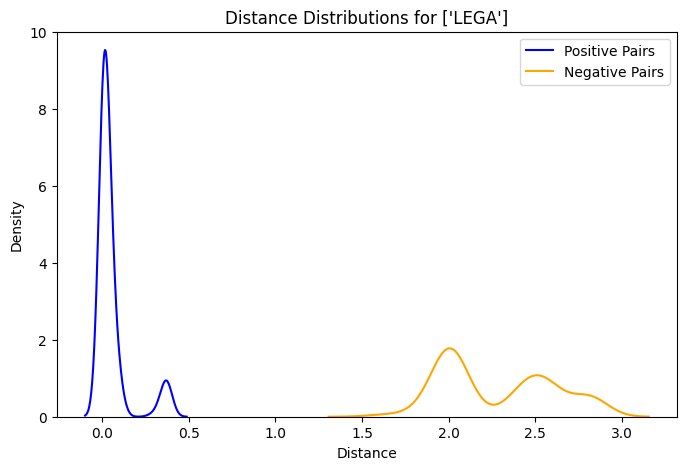

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [246 231]
Party: ['M5S']
  - F1 Score: 1.000
  - Accuracy: 1.000
  - Number of Test Samples: 477



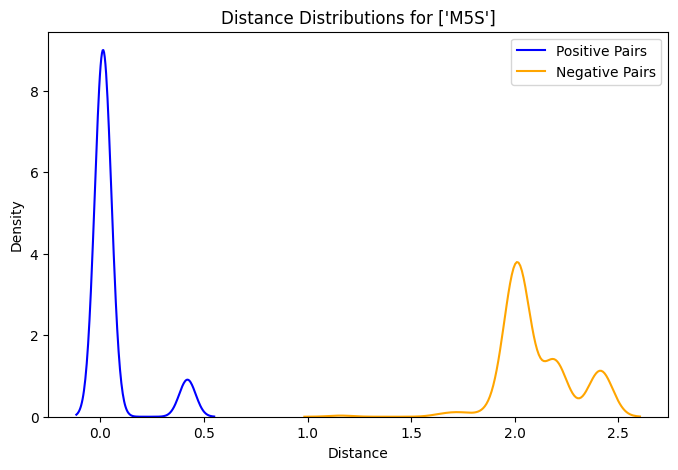

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [286 253]
Party: ['PD']
  - F1 Score: 1.000
  - Accuracy: 1.000
  - Number of Test Samples: 539



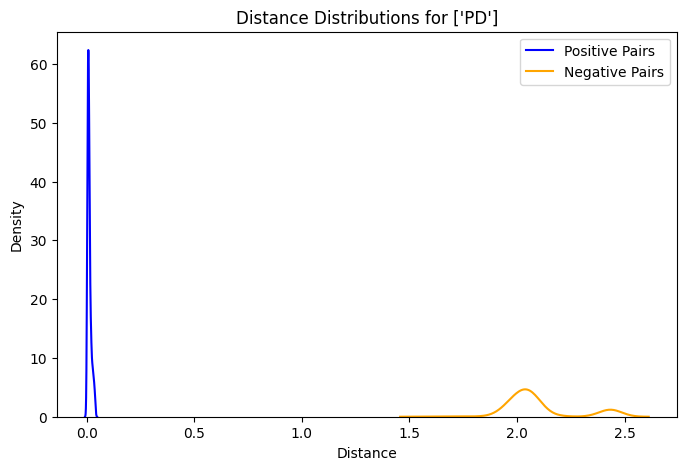

In [115]:
# Store metrics for each party, including the mixed-party category (-1)
party_metrics = {}
party_metrics['all_parties'] = {
    'f1_score': f1_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred),
    'test_samples': len(y_test)
}

# Include metrics for each party
for party_idx, party_name in enumerate(main_parties):
    # Get indices for this party's pairs
    party_indices = [i for i, p in enumerate(party_labels_test) if p == party_idx]

    # Get true labels and predictions for this party
    y_test_party = y_test[party_indices]
    y_pred_party = y_pred[party_indices]

    from sklearn.metrics import precision_recall_fscore_support as score

    precision, recall, fscore, support = score(y_test_party, y_pred_party)

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))


    # Calculate F1-score and accuracy for this party
    f1 = f1_score(y_test_party, y_pred_party)
    accuracy = accuracy_score(y_test_party, y_pred_party)

    # Store and print results for this party
    party_metrics[party_name] = {
        'f1_score': f1,
        'accuracy': accuracy,
        'test_samples': len(y_test_party)
    }
    print(f"Party: {party_name}")
    print(f"  - F1 Score: {f1:.3f}")
    print(f"  - Accuracy: {accuracy:.3f}")
    print(f"  - Number of Test Samples: {len(y_test_party)}\n")

    # Get distances for positive and negative pairs for this party
    positive_distances = distances[party_indices][y_test_party == 1]
    negative_distances = distances[party_indices][y_test_party == 0]

    # Plot distance distributions for positive and negative pairs
    plt.figure(figsize=(8, 5))
    sns.kdeplot(positive_distances.ravel(), label='Positive Pairs', color="blue")
    sns.kdeplot(negative_distances.ravel(), label='Negative Pairs', color="orange")
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.title(f'Distance Distributions for {party_name}')
    plt.legend()
    plt.show()


In [116]:
party_metrics_df= pd.DataFrame.from_dict(party_metrics, orient='index')
party_metrics_df = party_metrics_df.round(3)
print(f"{ads} | Siamese Network Metrics for Each Party:")
display(party_metrics_df)

zero-shot | Siamese Network Metrics for Each Party:


,f1_score,accuracy,test_samples
all_parties,0.994,0.994,3523
['3POLO'],1.000,1.000,470
['AVD'],1.000,1.000,491
['FDI'],0.952,0.957,486
['FI'],1.000,1.000,553
['LEGA'],1.000,1.000,507
['M5S'],1.000,1.000,477
['PD'],1.000,1.000,539


# Cross-Validation Implementation

In [117]:
# Initialize dictionaries to store metrics
party_metrics = {}
party_metrics['all_parties'] = {
    'f1_score': [],
    'accuracy': [],
    'test_samples': []
}

for party in main_parties:
    party_metrics[party] = {
        'f1_score': [],
        'accuracy': [],
        'test_samples': []
    }

# Define StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create pairs and labels
pairs, labels_out, party_labels_out = create_pairs(ordered_embeddings, party_labels)
print(f"Number of pairs: {len(pairs)}\n")     # 100*99/2 * 7 * 2

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Perform cross-validation evaluation
for fold, (train_index, test_index) in tqdm(enumerate(skf.split(ordered_embeddings, party_labels), 1), total=n_splits, desc='Cross-Validation Folds'):

    # Start
    # Generate train-test indices
    train_embeddings, test_embeddings = ordered_embeddings[train_index], ordered_embeddings[test_index]
    train_labels, test_labels = party_labels[train_index], party_labels[test_index]

    # # Verify the distribution in training and test sets
    # print(f"Number of train embeddings: {len(train_embeddings)}")
    # unique, train_counts = np.unique(train_labels, return_counts=True)
    # print("Training set party distribution:", dict(zip(unique, train_counts)))

    # print(f"Number of test embeddings: {len(test_embeddings)}")
    # unique, test_counts = np.unique(test_labels, return_counts=True)
    # print("Test set party distribution:", dict(zip(unique, test_counts)))

    # Convert train and test embeddings into sets for fast membership checking
    train_embeddings_set = set(map(tuple, train_embeddings))
    test_embeddings_set = set(map(tuple, test_embeddings))

    # Filter the pairs and party labels
    train_indices = []
    test_indices = []

    for i, pair in enumerate(pairs):
        embedding_a, embedding_b = tuple(pair[0]), tuple(pair[1])

        if embedding_a in train_embeddings_set and embedding_b in train_embeddings_set:
            train_indices.append(i)

        if embedding_a in test_embeddings_set and embedding_b in test_embeddings_set:
            test_indices.append(i)

    # Final training and testing sets
    X_train_fold = pairs[train_indices]
    y_train_fold = labels_out[train_indices]
    party_labels_train_fold = party_labels_out[train_indices]
    print(f"\nNumber of train pairs: {len(X_train_fold)}")

    X_test_fold = pairs[test_indices]
    y_test_fold = labels_out[test_indices]
    party_labels_test_fold = party_labels_out[test_indices]  # Use for per-party evaluation
    print(f"Number of test pairs: {len(X_test_fold)}")
    #End


    # Build the model
    model_fold = build_siamese_network(input_dim)
    # Compile the model
    model_fold.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-5))
    # Train the model
    model_fold.fit([X_train_fold[:, 0], X_train_fold[:, 1]], y_train_fold,
                            validation_data=([X_test_fold[:, 0], X_test_fold[:, 1]], y_test_fold),
                            batch_size=16, epochs=100, callbacks=[early_stopping])

    # Predict distances using the Siamese Network
    distances = model_fold.predict([X_test_fold[:, 0], X_test_fold[:, 1]]).flatten()

    # Separate positive and negative distances
    positive_distances = distances[y_test_fold == 1]
    negative_distances = distances[y_test_fold == 0]

    # Calculate mean distances
    midpoint_threshold = (np.mean(positive_distances) + np.mean(negative_distances)) / 2

    # Make predictions based on the threshold
    y_pred_fold = (distances <= midpoint_threshold).astype('float32')


    # Evaluation
    # Overall Metrics
    f1_overall = f1_score(y_test_fold, y_pred_fold, zero_division=0)
    accuracy_overall = accuracy_score(y_test_fold, y_pred_fold)

    party_metrics['all_parties']['f1_score'].append(f1_overall)
    party_metrics['all_parties']['accuracy'].append(accuracy_overall)
    party_metrics['all_parties']['test_samples'].append(len(y_test_fold))

    # Metrics per Party
    for party_idx, party_name in enumerate(main_parties):
        # Get indices for this party's pairs
        # party_indices = (party_labels_test_fold == party_idx) & (y_test_fold == 1)
        party_indices_old = [i for i, p in enumerate(party_labels_test_fold) if p == party_idx]
        # print()
        # print(len(party_indices), party_indices)
        # print(len(party_indices_old), party_indices_old)
        # print(len(y_test_fold))
        while party_indices_old[-1] >= len(y_test_fold):
            party_indices_old.pop()
        # print(len(party_indices_old), party_indices_old)

        y_true_party = y_test_fold[party_indices_old]
        y_pred_party = y_pred_fold[party_indices_old]

        # Calculate F1-score and Accuracy
        f1 = f1_score(y_true_party, y_pred_party, zero_division=0)
        accuracy = accuracy_score(y_true_party, y_pred_party)

        # Store metrics
        party_metrics[party_name]['f1_score'].append(f1)
        party_metrics[party_name]['accuracy'].append(accuracy)
        party_metrics[party_name]['test_samples'].append(len(y_true_party))



Number of positive pairs: 42735
Number of negative pairs: 42735
Number of pairs: 85470



Cross-Validation Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Number of train pairs: 55020
Number of test pairs: 3542
Epoch 1/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.8008 - val_loss: 0.3192
Epoch 2/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3152 - val_loss: 0.2139
Epoch 3/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1814 - val_loss: 0.1832
Epoch 4/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1227 - val_loss: 0.1665
Epoch 5/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0905 - val_loss: 0.1604
Epoch 6/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0714 - val_loss: 0.1575
Epoch 7/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0594 - val_loss: 0.1526
Epoch 8/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0502 - val_loss: 0.1529
Epoch 9/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0432 - val_loss: 0.1522
Epoch 10/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0381 - val_loss: 0.1509
Epoch 11/100
3439/3439 ━━━━━━━━━━━━━━━━━━━━ 9s 2

Cross-Validation Folds:  20%|██        | 1/5 [06:57<27:49, 417.39s/it]


Number of train pairs: 54699
Number of test pairs: 3403
Epoch 1/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.7853 - val_loss: 0.2847
Epoch 2/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3357 - val_loss: 0.1716
Epoch 3/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1826 - val_loss: 0.1257
Epoch 4/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1150 - val_loss: 0.1109
Epoch 5/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0832 - val_loss: 0.1038
Epoch 6/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0666 - val_loss: 0.0948
Epoch 7/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0549 - val_loss: 0.0915
Epoch 8/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0470 - val_loss: 0.0902
Epoch 9/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0405 - val_loss: 0.0855
Epoch 10/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0360 - val_loss: 0.0846
Epoch 11/100
3419/3419 ━━━━━━━━━━━━━━━━━━━━ 12s 2m

Cross-Validation Folds:  40%|████      | 2/5 [15:22<23:26, 468.82s/it]


Number of train pairs: 54946
Number of test pairs: 3448
Epoch 1/100
3435/3435 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.7765 - val_loss: 0.2917
Epoch 2/100
3435/3435 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3106 - val_loss: 0.1708
Epoch 3/100
3435/3435 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1768 - val_loss: 0.1239
Epoch 4/100
3435/3435 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1161 - val_loss: 0.1072
Epoch 5/100
3435/3435 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0866 - val_loss: 0.0965
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Cross-Validation Folds:  60%|██████    | 3/5 [16:21<09:23, 281.81s/it]


Number of train pairs: 55154
Number of test pairs: 3596
Epoch 1/100
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.8165 - val_loss: 0.2706
Epoch 2/100
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.3069 - val_loss: 0.1582
Epoch 3/100
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1742 - val_loss: 0.1213
Epoch 4/100
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1162 - val_loss: 0.1046
Epoch 5/100
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0876 - val_loss: 0.0980
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Cross-Validation Folds:  80%|████████  | 4/5 [17:27<03:16, 196.75s/it]


Number of train pairs: 55218
Number of test pairs: 3509
Epoch 1/100
3452/3452 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7441 - val_loss: 0.2717
Epoch 2/100
3452/3452 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2956 - val_loss: 0.1683
Epoch 3/100
3452/3452 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1603 - val_loss: 0.1345
Epoch 4/100
3452/3452 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1019 - val_loss: 0.1220
Epoch 5/100
3452/3452 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0759 - val_loss: 0.1146
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Cross-Validation Folds: 100%|██████████| 5/5 [18:28<00:00, 221.67s/it]


In [118]:
# Compile metrics into a list
metrics_list = []
for party in ['all_parties'] + main_parties:
    if party == 'all_parties':
        metrics_list.append({
            'Party': party,
            'F1-score': np.mean(party_metrics[party]['f1_score']),
            'Std F1-score': np.std(party_metrics[party]['f1_score']),
            'Accuracy': np.mean(party_metrics[party]['accuracy']),
            'Std Accuracy': np.std(party_metrics[party]['accuracy']),
            'Test Samples': np.sum(party_metrics[party]['test_samples'])
        })
    else:
        metrics_list.append({
            'Party': party,
            'F1-score': np.mean(party_metrics[party]['f1_score']),
            'Std F1-score': np.std(party_metrics[party]['f1_score']),
            'Accuracy': np.mean(party_metrics[party]['accuracy']),
            'Std Accuracy': np.std(party_metrics[party]['accuracy']),
            'Test Samples': np.sum(party_metrics[party]['test_samples'])
        })

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Party', inplace=True)
metrics_df = metrics_df.round(3)

# Display the DataFrame
print(f"{ads} | Siamese Network Metrics for Each Party:")
display(metrics_df)


zero-shot | Siamese Network Metrics for Each Party:


,F1-score,Std F1-score,Accuracy,Std Accuracy,Test Samples
Party,,,,,
all_parties,0.952,0.019,0.952,0.020,17498
['3POLO'],0.997,0.003,0.998,0.003,2437
['AVD'],0.903,0.065,0.905,0.065,2432
['FDI'],0.932,0.042,0.931,0.043,2434
['FI'],0.913,0.049,0.916,0.038,2458
['LEGA'],0.990,0.019,0.990,0.020,2646
['M5S'],0.952,0.038,0.951,0.039,2611
['PD'],0.969,0.026,0.969,0.027,2480


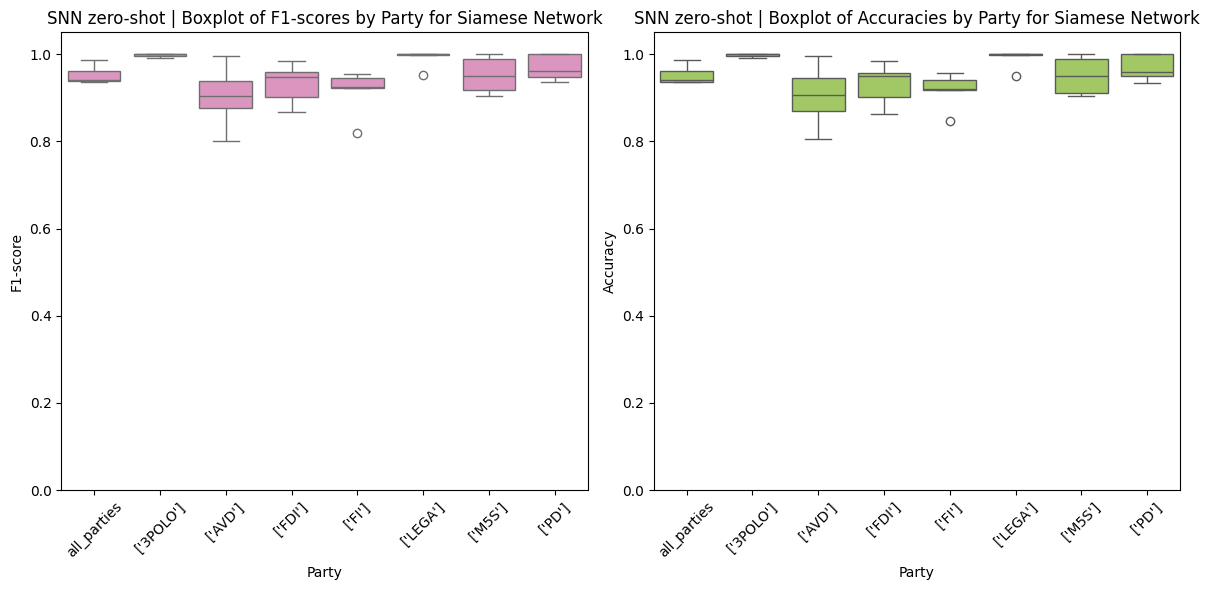

In [119]:
# Prepare data for boxplots
# For F1-scores
f1_data = []
for party in ['all_parties'] + main_parties:
    for score in party_metrics[party]['f1_score']:
        f1_data.append({'Party': party, 'F1-score': score})

f1_df = pd.DataFrame(f1_data)

# For Accuracies
accuracy_data = []
for party in ['all_parties'] + main_parties:
    for acc in party_metrics[party]['accuracy']:
        accuracy_data.append({'Party': party, 'Accuracy': acc})

accuracy_df = pd.DataFrame(accuracy_data)

# Melt the F1 DataFrame for seaborn
f1_melted = f1_df.copy()
f1_melted['Metric'] = 'F1-score'

# Melt the Accuracy DataFrame
accuracy_melted = accuracy_df.copy()
accuracy_melted['Metric'] = 'Accuracy'

# Combine both
combined_metrics = pd.concat([f1_melted, accuracy_melted], ignore_index=True)

sns.set_palette("Set2")
current_palette = sns.color_palette()

# Create Boxplot for F1-scores and Accuracies
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Boxplot for F1-scores on the first subplot (axes[0])
sns.boxplot(x='Party', y='F1-score', data=f1_df, ax=axes[0], color=current_palette[3])
axes[0].set_title(f'SNN {ads} | Boxplot of F1-scores by Party for Siamese Network')
axes[0].set_xlabel('Party')
axes[0].set_ylabel('F1-score')
axes[0].set_ylim(0, 1.05)
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for Accuracies on the second subplot (axes[1])
sns.boxplot(x='Party', y='Accuracy', data=accuracy_df, ax=axes[1], color=current_palette[4])
axes[1].set_title(f'SNN {ads} | Boxplot of Accuracies by Party for Siamese Network')
axes[1].set_xlabel('Party')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.05)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


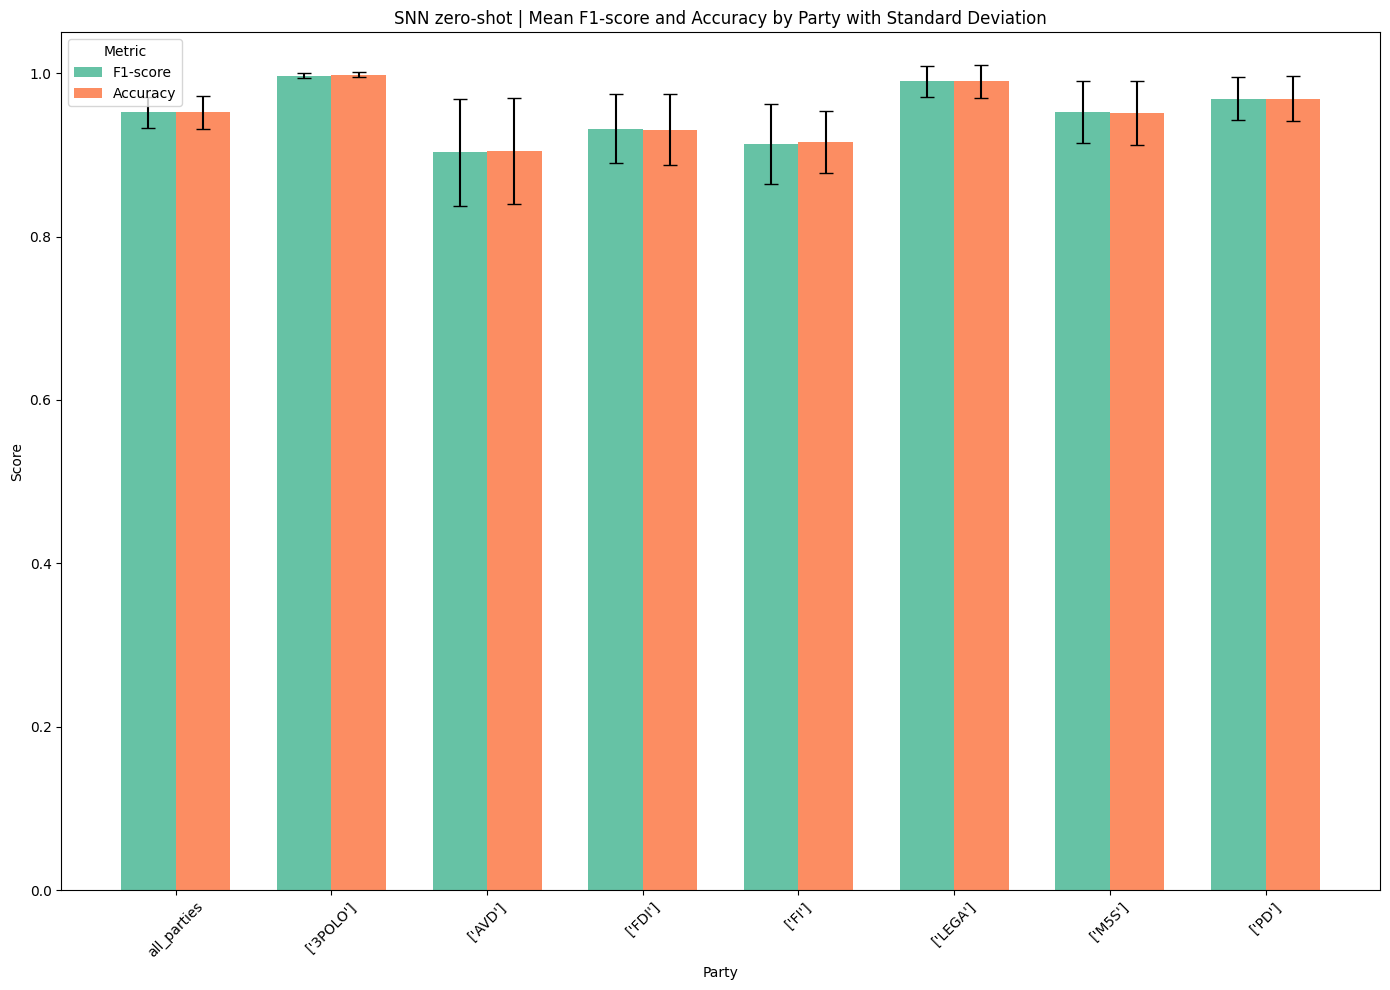

In [120]:
metrics_df_reset = metrics_df.reset_index()

# Define the metrics to plot
metrics_to_plot = ['F1-score', 'Accuracy']
num_metrics = len(metrics_to_plot)
num_parties = len(metrics_df_reset)

# Define the bar width and positions
bar_width = 0.35
indices = np.arange(num_parties)

# Initialize the matplotlib figure
plt.figure(figsize=(14, 10))

# Plot each metric
for i, metric in enumerate(metrics_to_plot):
    means = metrics_df_reset[metric]
    stds = metrics_df_reset[f'Std {metric}']
    plt.bar(
        indices + i * bar_width,
        means,
        bar_width,
        yerr=stds,
        capsize=5,
        label=metric
    )

# Customize the plot
plt.title(f'SNN {ads} | Mean F1-score and Accuracy by Party with Standard Deviation')
plt.xlabel('Party')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(indices + bar_width / 2, metrics_df_reset['Party'], rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


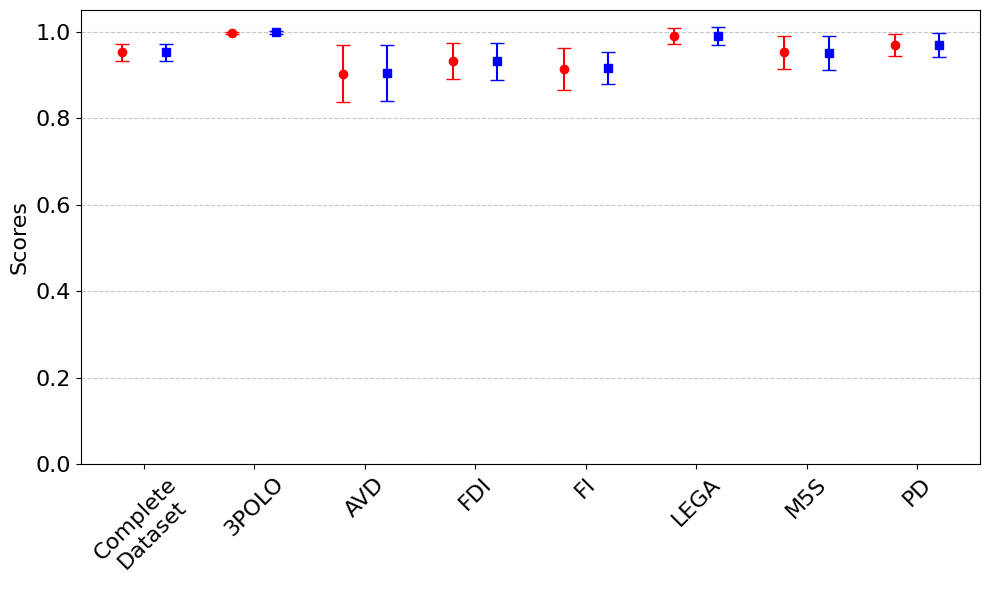

In [121]:
# Reset index to get 'Party' as a column
metrics_df_reset = metrics_df.reset_index()

# Number of parties
num_parties = len(metrics_df_reset)
indices = np.arange(num_parties)

# Define width for offset
offset = 0.2

plt.figure(figsize=(10, 6))

# Plot F1-score with left offset
plt.errorbar(
    x=indices - offset,
    y=metrics_df_reset['F1-score'],
    yerr=metrics_df_reset['Std F1-score'],
    fmt='o',
    ecolor='red',
    capsize=5,
    label='F1-score',
    color='red'
)

# Plot Accuracy with right offset
plt.errorbar(
    x=indices + offset,
    y=metrics_df_reset['Accuracy'],
    yerr=metrics_df_reset['Std Accuracy'],
    fmt='s',
    ecolor='blue',
    capsize=5,
    label='Accuracy',
    color='blue'
)

# Set x-ticks to center between the two metrics
plt.xticks(ticks=indices, labels=main_parties_labels, rotation=45)

# Add titles and labels
# plt.title(f'SNN {ads} | Mean F1-score and Accuracy by Party with Standard Deviation')
# plt.xlabel('Party')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Scores', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 1.05)

# Add legend
# plt.legend()

# Optional: Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()
